In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from math import ceil
import time
import matplotlib.pyplot as plt
import seaborn as sns
tf.compat.v1.disable_eager_execution()

###Set hyper parameters

In [ ]:
n_classes = 10
n_batch = 128
n_epoch = 15
regularizer_rate = 0.005
learning_rate = 0.001

###Load data
####Following funtion loads MNIST dataset hosted in Yann LeCun website "http://yann.lecun.com/exdb/mnist/" 

Loading MNIST dataset
Data is successfully loaded


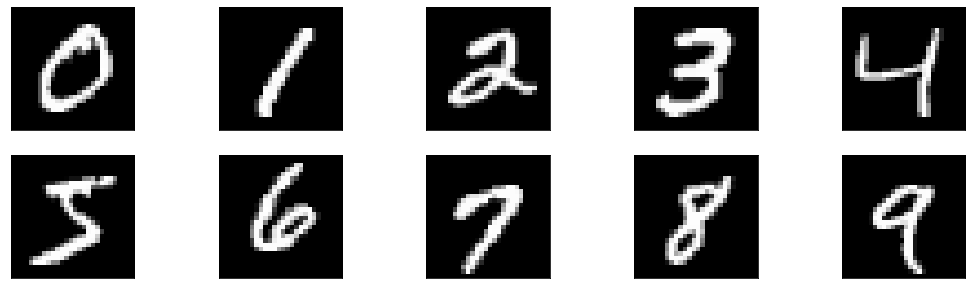

In [ ]:
print('Loading MNIST dataset')
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255
x_test = x_test/255
print('Data is successfully loaded')

fig_size = [18, 5]
label_fontsize = 20
fig = plt.figure(figsize=fig_size)
for img_sample in np.arange(10):  
  img_index = np.where(y_train==img_sample)[0][0]
  img = x_train[img_index]
  ax = plt.subplot(2, 5, img_sample+1)
  ax.imshow(img, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

###Convert y labels (both test and train) to one-hot vectors

In [ ]:
print('Converting y labels of test and train data to one-hot vectors')
y_train_one_hot = tf.one_hot(y_train, n_classes)
y_train_one_hot = y_train_one_hot.eval(session=tf.compat.v1.Session())
y_test_one_hot = tf.one_hot(y_test, n_classes)
y_test_one_hot = y_test_one_hot.eval(session=tf.compat.v1.Session())

Converting y labels of test and train data to one-hot vectors


###Reshape input images to flattened vectors

In [ ]:
print('Reshaping test and train input data to flattened vectors')
x_train_reshape = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test_reshape = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))

Reshaping test and train input data to flattened vectors


###Initialise place holders for data and label

In [ ]:
n_inp_features = x_train_reshape.shape[-1]
n_data_split = ceil(x_train.shape[0]/n_batch)
x = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, n_inp_features])
y = tf.compat.v1.placeholder(dtype=tf.float32)

###Initalize variables for weight matrix

In [ ]:
layer = 0
layer_dict = {}
layer_dict[layer] = {'weights':tf.Variable(tf.random.normal([n_inp_features, n_classes], stddev=1/tf.sqrt(float(n_inp_features))), dtype=tf.float32, name='weights_{}'.format(layer)), 
          'biases':tf.Variable(tf.random.normal([n_classes]), dtype=tf.float32, name='biases_{}'.format(layer))}

###Model Logistic regression

In [ ]:
def logistic_regression(data):
  W = layer_dict[0]['weights']
  b = layer_dict[0]['biases']
  return tf.nn.softmax(tf.add(tf.matmul(data, W), b))

###Train Logistic regression

In [ ]:
def train_logistic_regression(x):
  start_time = time.time()

  prediction = logistic_regression(x)
  correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
  layer_weight = layer_dict[0]['weights']
  layer_bias = layer_dict[0]['biases']
  weight_regularization = regularizer_rate*tf.nn.l2_loss(layer_weight)
  weight_list = []
  bias_list = []
  weight_list.append(layer_weight)
  bias_list.append(layer_bias)
  optimize_var_list = weight_list + bias_list
  
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y)) + weight_regularization
  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost, var_list=optimize_var_list)

  with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    data_index_arr = np.arange(x_train.shape[0])
    epch_cost_list = []
    epch_accuracy_list = []
    for epoch in range(n_epoch):
      np.random.shuffle(data_index_arr)
      cost_ = 0
      for index_split in np.array_split(data_index_arr, n_data_split):
        x_train_batch = x_train_reshape[index_split]
        y_train_batch = y_train_one_hot[index_split]
        sess.run(optimizer, feed_dict={x:x_train_batch, y:y_train_batch})
        cost_ = cost_ + sess.run(cost, feed_dict={x:x_train_batch, y:y_train_batch})
      epch_cost_list.append(cost_)
      epch_accuracy = sess.run(accuracy, feed_dict={x:x_train_reshape, y:y_train_one_hot})
      epch_accuracy_list.append(epch_accuracy)
      print('Epoch = {}, cost = {}, accuracy = {}'.format(epoch, cost_, epch_accuracy))

    print('Accuracy on test dataset = {}'.format(sess.run(accuracy, feed_dict={x:x_test_reshape, y:y_test_one_hot})))

    print('Plotting cost function vs training epoch')
    fig_size = [10, 5]
    label_fontsize = 18
    fig = plt.figure(figsize=fig_size)
    ax = plt.subplot(131)
    epoch_arr = np.arange(n_epoch)
    ax.plot(epoch_arr, epch_cost_list, linewidth=3)
    ax.set_xlabel('Epoch number', fontsize=label_fontsize)
    ax.set_ylabel('Cost function', fontsize=label_fontsize)
    ax.set_title('Cost function vs training epoch', fontsize=label_fontsize)
    ax.set_xticks(epoch_arr)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    print('Plotting accuracy vs training epoch')
    ax = plt.subplot(133)
    epoch_arr = np.arange(n_epoch)
    ax.plot(epoch_arr, epch_accuracy_list, linewidth=3)
    ax.set_xlabel('Epoch number', fontsize=label_fontsize)
    ax.set_ylabel('Accuracy', fontsize=label_fontsize)
    ax.set_title('Accuracy vs training epoch', fontsize=label_fontsize)
    ax.set_xticks(epoch_arr)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()

    print('Saving checkpoints...')
    variable_list = []
    layer = 0
    globals()[f"weight_{layer}"] = layer_dict[layer]['weights']
    globals()[f"bias_{layer}"] = layer_dict[layer]['biases']
    variable_list.append(globals()[f"weight_{layer}"])
    variable_list.append(globals()[f"bias_{layer}"])
    saver = tf.compat.v1.train.Saver(variable_list)
    save_path = saver.save(sess, "./saved_variables_logistic_regression.ckpt")
    print('Checkpoints are saved')
    end_time = time.time()
    tot_time = round((end_time-start_time)/60, 2)
    print('Logistic regression training is completed in {} minutes'.format(tot_time))


###Run the network

Epoch = 0, cost = 863.2020568847656, accuracy = 0.8791833519935608
Epoch = 1, cost = 820.1555382013321, accuracy = 0.888700008392334
Epoch = 2, cost = 818.6963338851929, accuracy = 0.8888000249862671
Epoch = 3, cost = 818.327671289444, accuracy = 0.8905666470527649
Epoch = 4, cost = 818.0618361234665, accuracy = 0.8899999856948853
Epoch = 5, cost = 817.9011317491531, accuracy = 0.8894333243370056
Epoch = 6, cost = 817.7370653152466, accuracy = 0.888949990272522
Epoch = 7, cost = 817.5158770084381, accuracy = 0.8881499767303467
Epoch = 8, cost = 817.3935967683792, accuracy = 0.8889333605766296
Epoch = 9, cost = 817.2943387031555, accuracy = 0.8883333206176758
Epoch = 10, cost = 817.2065362930298, accuracy = 0.8891500234603882
Epoch = 11, cost = 817.1009976863861, accuracy = 0.8872166872024536
Epoch = 12, cost = 817.0466001033783, accuracy = 0.8884999752044678
Epoch = 13, cost = 816.9685750007629, accuracy = 0.8909333348274231
Epoch = 14, cost = 816.9465305805206, accuracy = 0.8894166946

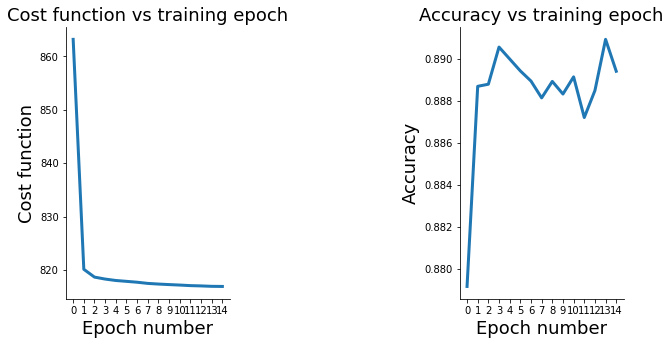

Saving checkpoints...
Checkpoints are saved
Logistic regression training is completed in 0.39 minutes


In [ ]:
train_logistic_regression(x)


###Prediction using the trained network 
####(a) Set the prediction function and load the saved weights

In [ ]:
variable_list = []
layer = 0
globals()[f"weight_{layer}"] = layer_dict[layer]['weights']
globals()[f"bias_{layer}"] = layer_dict[layer]['biases']
variable_list.append(globals()[f"weight_{layer}"])
variable_list.append(globals()[f"bias_{layer}"])
saver = tf.compat.v1.train.Saver(variable_list)

def classify(image):
  image = image[tf.newaxis, ..., tf.newaxis]
  image_ = tf.image.resize(image, [28, 28])
  image_ = tf.reshape(image_, [28, 28])
  image_ = image_.eval(session=tf.compat.v1.Session())
  image_reshape = image_.reshape(-1, np.prod(image_.shape[0:]))

  prediction = logistic_regression(x)

  with tf.compat.v1.Session() as sess:
    saver.restore(sess, "./saved_variables_logistic_regression.ckpt")
    layer_dict = {}
    layer = 0
    layer_dict[layer] = {'weights':globals()[f"weight_{layer}"], 'biases':globals()[f"bias_{layer}"]}

    prediction_ = sess.run(prediction, feed_dict={x:image_reshape})
    prediction_ = prediction_[0]
    return prediction_


###Prediction using the trained network 
####(b) Input a test image to the network

INFO:tensorflow:Restoring parameters from ./saved_variables_logistic_regression.ckpt


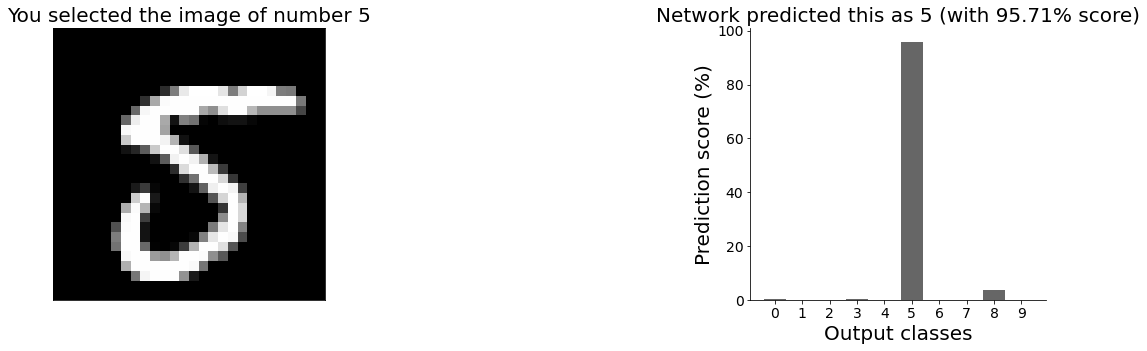

In [ ]:
# There are a total of 10,000 test images. Select any one of them below ranging from 0-9999 
# (For example, give test_image_index = 0, for inputing the first test image)
test_image_index = 3321

# Get the test image
input_class = y_test[test_image_index]
input_image = x_test[test_image_index]
prediction_out = classify(x_test[test_image_index])*100
predicted_max_score = round(prediction_out.max(),2)

# Plot input image
fig_size = [18, 5]
label_fontsize = 20
fig = plt.figure(figsize=fig_size)
ax = plt.subplot(131)
ax.imshow(input_image, cmap='gray')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('You selected the image of number {}'.format(input_class), fontsize=label_fontsize)

# Plot network output
ax = plt.subplot(133)
class_arr = np.arange(n_classes)
ax.bar(class_arr, prediction_out, linewidth=3, color=[0.4,0.4,0.4])
ax.set_xlabel('Output classes', fontsize=label_fontsize)
ax.set_ylabel('Prediction score (%)', fontsize=label_fontsize)
ax.set_title('Network predicted this as {0} (with {1:.2f}% score)'.format(np.argmax(prediction_out), predicted_max_score), fontsize=label_fontsize)
ax.set_xticks(class_arr)
ax.set_ylim(0,101)
ax.tick_params(labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show() 